In [1]:
import torch
# For dataset preparation
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as TF
# For building neural networks
import torch.nn as nn
import torch.nn.functional as F
# For training
from torch.optim import SGD, Adam
# For visualization
import matplotlib.pyplot as plt

# Preparing the dataset

In [2]:
training_data = datasets.MNIST(
    # Where the data are stored. If this is a relative path, 
    # the path is assumed to start from the current working directory. 
    # Therefore you can find a data folder coming together with this notebook.
    root="./data",  
    train=True, 
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64
training_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Defining the model

In [5]:
class VAECNN(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # To simply the code, let's use Sequential to define the encoder and the decoder,
        # instead of define a  
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(16, 3, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(147, latent_dim*2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 147),
            nn.Unflatten(1, (3, 7, 7)),
            nn.ConvTranspose2d(3, 16, 3, stride=2, output_padding=1, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, output_padding=1, padding=1),  
            nn.Sigmoid(),  # for pixel values between 0 and 1
        )
    
    def reparameterize(self, mu, logvar):
        # NOTE logvar is log σ^2. This explains why we need a factor of 1/2 below.
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x).chunk(2, dim=1)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar


In [6]:
# Let's try to check if AutoencoderCNN works

model = VAECNN(32)
res = model(training_data[0][0].unsqueeze(0))
print(res[0].size())
print(res[1].size())
print(res[2].size())

torch.Size([1, 1, 28, 28])
torch.Size([1, 32])
torch.Size([1, 32])


# Training: what typically works

In [7]:
def vae_loss(x_recon, x, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction="sum")
    kl_loss = 0.02 * torch.sum(-1 + logvar.exp() - logvar + mu.pow(2))
    return recon_loss + kl_loss

def train_adam(model, dataloader, lr, epoches):
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epoches):
        model.train()
        for X, Y in dataloader:
            X = X.to(device)
            Y = Y.to(device)
            
            Xhat, mu, logvar = model(X)
            loss = vae_loss(Xhat, X, mu, logvar)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        model.eval() 
        with torch.no_grad():
            for X, Y in test_dataloader:
                X = X.to(device)
                Y = Y.to(device)
                
                Xhat, mu, logvar = model(X)
                loss = F.mse_loss(Xhat, X)

                print(f"epoch {epoch:>3d}   test loss avg: {loss:>5f}")

In [8]:
model = model.to("cuda")
train_adam(model, training_dataloader, lr=0.002, epoches=10)

epoch   0   test loss avg: 0.012485
epoch   1   test loss avg: 0.009875
epoch   2   test loss avg: 0.009247
epoch   3   test loss avg: 0.008754
epoch   4   test loss avg: 0.008594
epoch   5   test loss avg: 0.008288
epoch   6   test loss avg: 0.008407
epoch   7   test loss avg: 0.008165
epoch   8   test loss avg: 0.008069
epoch   9   test loss avg: 0.007967


Time for a test

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


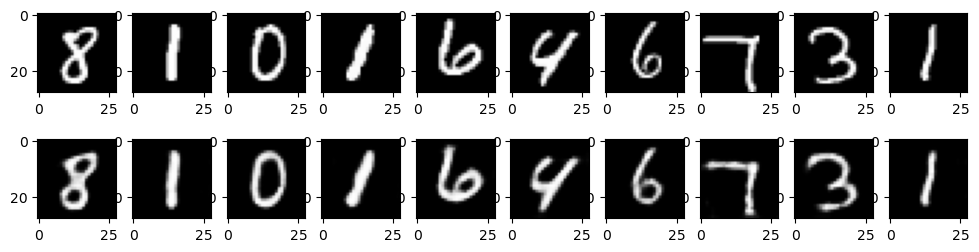

In [9]:
def show_reconstructed_images(model):
    for x, y in test_dataloader:
        break

    x = x.to(device)
    xb = model(x)[0]

    x = x.to("cpu")
    xb = xb.to("cpu")

    print(x.size())
    print(xb.size())

    with torch.no_grad():
        idxs = range(134, 144)
        fig, axes = plt.subplots(2, len(idxs), figsize=(12, 3))
        for i, img_idx in enumerate(idxs):
            axes[0, i].imshow(x[img_idx, 0, :, :], cmap="gray")
            axes[1, i].imshow(xb[img_idx, 0, :, :], cmap="gray")
            
        plt.show()

show_reconstructed_images(model)

Does the model work with rotation?

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


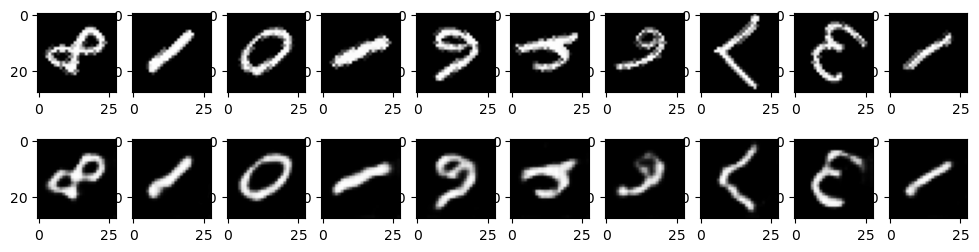

In [10]:
def show_reconstructed_images_rotated(model, angle):
    for x, y in test_dataloader:
        break

    x = TF.rotate(x, angle)
    x = x.to(device)
    xb = model(x)[0]

    x = x.to("cpu")
    xb = xb.to("cpu")

    print(x.size())
    print(xb.size())

    with torch.no_grad():
        idxs = range(134, 144)
        fig, axes = plt.subplots(2, len(idxs), figsize=(12, 3))
        for i, img_idx in enumerate(idxs):
            axes[0, i].imshow(x[img_idx, 0, :, :], cmap="gray")
            axes[1, i].imshow(xb[img_idx, 0, :, :], cmap="gray")
            
        plt.show()

show_reconstructed_images_rotated(model, 135)

# Exploring the structure of the latent space

In [11]:
from sklearn.manifold import TSNE

In [12]:
for x, y in test_dataloader:
    break

x = x.to(device)
y = y.to(device)
with torch.no_grad():
    x_hat, mu, logvar = model(x)

mu.size()

torch.Size([10000, 32])

torch.Size([1135, 32])


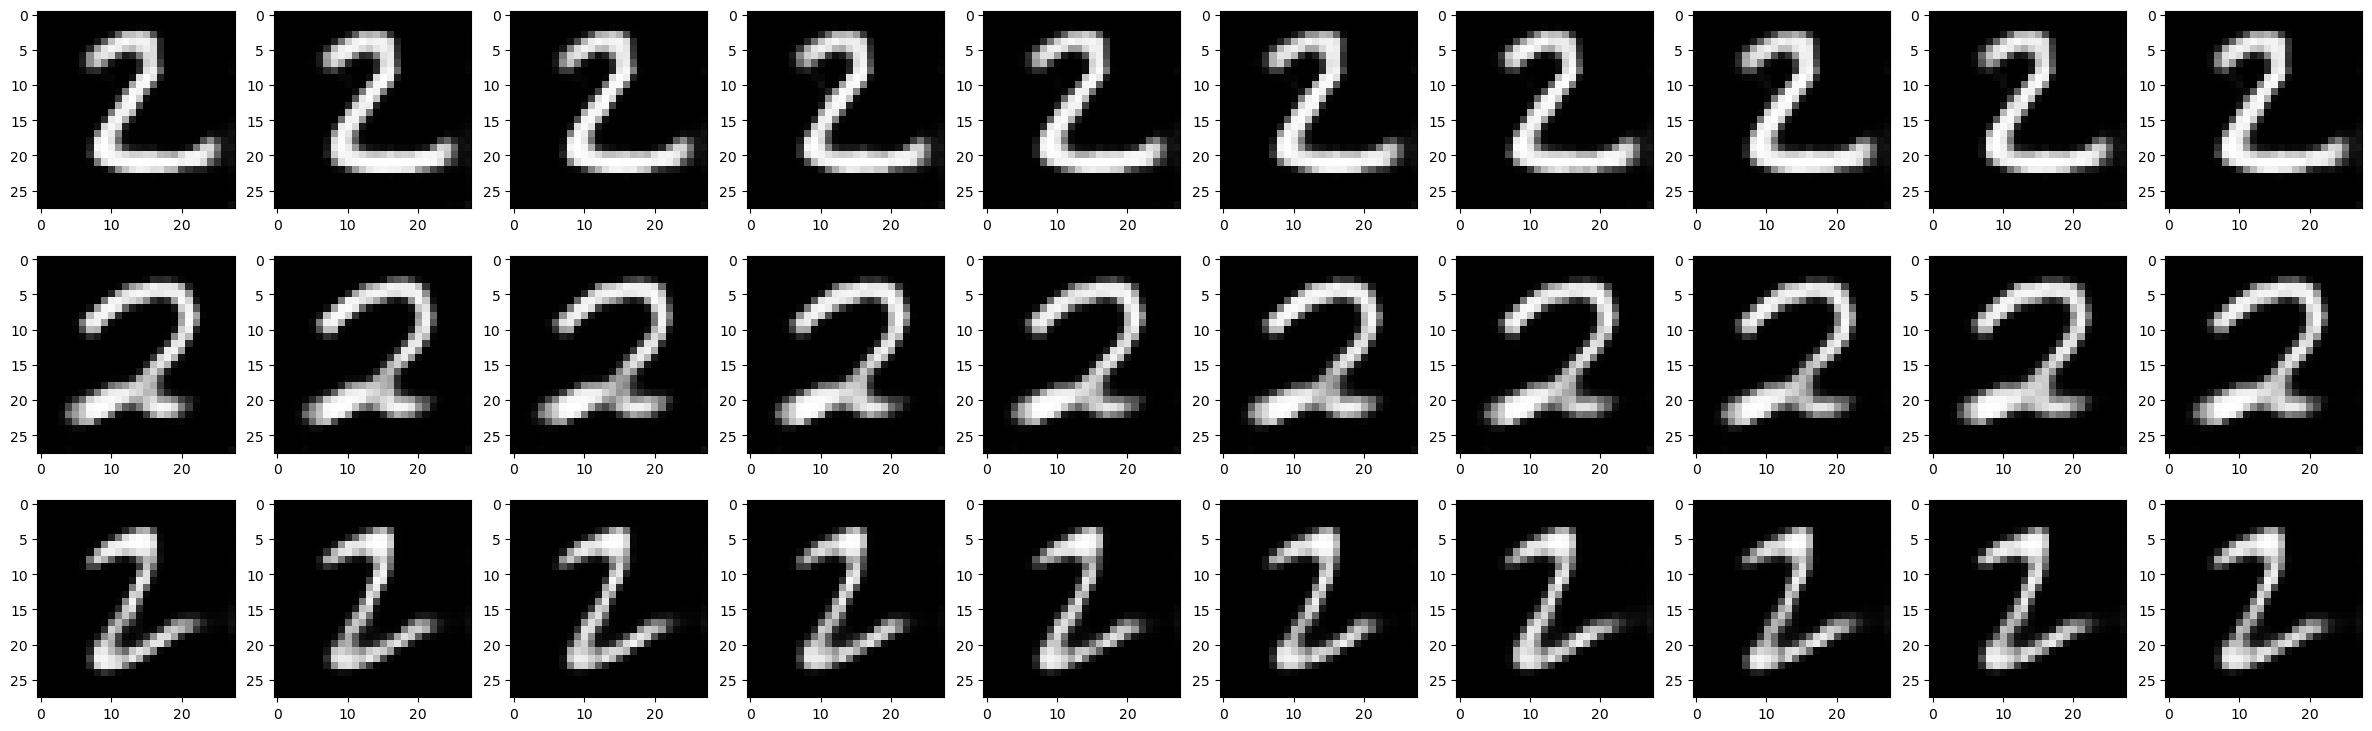

In [13]:
def select_digit(d):
    return model.reparameterize(mu[y == d, :], logvar[y == d, :])

print(select_digit(1).size())
# Display the decoding result of the latent space representation of the first sample that represents digit 1
# Note that due to the random eps variable in reparameterization,
# the image below is slightly different each time the code runs. 
test_idxs = [101, 304, 3]
d = 2
fig, axes = plt.subplots(len(test_idxs), 10, figsize=(30, 3*len(test_idxs)))
for i in range(10):
    for j in range(len(test_idxs)):
        axes[j, i].imshow(model.decoder(select_digit(d)[j].unsqueeze(0)).cpu().detach()[0, 0, :, :] , cmap="gray")

plt.show()

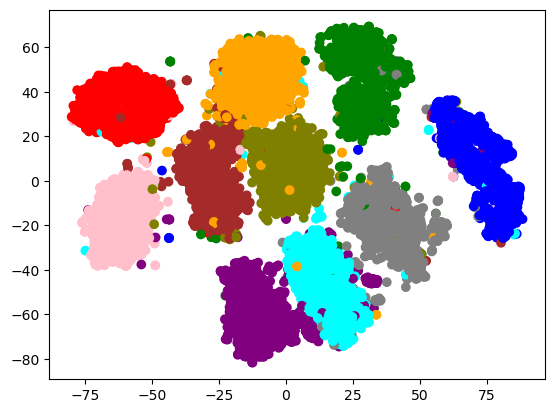

In [14]:
mu_cpu = mu.detach().cpu().numpy()
tsne = TSNE(2, random_state=42)
tsne_results = tsne.fit_transform(mu_cpu)

color_map = {
    0: 'red', 1: 'blue', 2: 'green', 3: 'orange', 4: 'purple',
    5: 'brown', 6: 'pink', 7: 'gray', 8: 'olive', 9: 'cyan'
}

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=list(map(lambda d: color_map[d], y.cpu().detach().numpy())))

Now we feed a randomly generated latent space representation to the decoder.
The result, expectedly, is not particularly meaningful - but it still looks like strikes in writing.


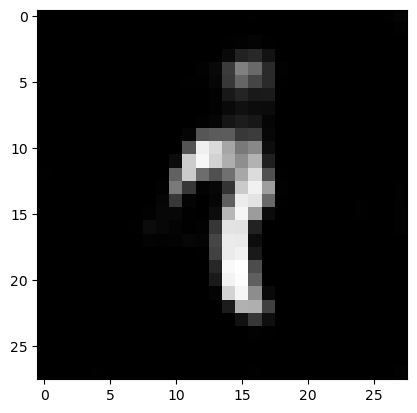

In [32]:
mu_rand = torch.randn(1, 32).to(device)
with torch.no_grad():
    x_hat_rand = model.decoder(mu_rand)

plt.imshow(x_hat_rand.cpu().numpy()[0, 0, :, :], cmap="gray")
plt.show()